In [51]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from metpy.plots import USCOUNTIES
import shapely.geometry as geom
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import numpy as np
from copy import copy
from shapely import geometry
from shapely.geometry.polygon import Polygon
import shapely.geometry as sgeom
from matplotlib.patches import Patch

In [2]:
ds1 = xr.open_dataset('met_em.d01.2018-11-08_000000.nc')
lat1 = ds1.XLAT_M.squeeze()
lon1 = ds1.XLONG_M.squeeze()
ds2 = xr.open_dataset('met_em.d02.2018-11-08_000000.nc')
lat2 = ds2.XLAT_M.squeeze()
lon2 = ds2.XLONG_M.squeeze()
ds3 = xr.open_dataset('met_em.d03.2018-11-08_000000.nc')
lat3 = ds3.XLAT_M.squeeze()
lon3 = ds3.XLONG_M.squeeze()

In [3]:
def plot_background(ax):
    ax.coastlines(resolution='10m', linewidth=2, color = '#261c00', zorder = 4)
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    ax.add_feature(political_boundaries, linestyle='-', edgecolor='#261c00', zorder =4)
    ax.add_feature(states, linestyle='-', edgecolor='#261c00',linewidth=2, zorder =4)
    ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='#261c00', linewidth=1, zorder = 1) #### Using Metpy's county shapefiles due to hi-resolution and they also help with spartial awareness
    #ax.add_feature(roads, facecolor='none', edgecolor='#261c00', zorder = 1, linewidth = 1) 
    return ax



def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels



In [4]:
cart_proj = ccrs.LambertConformal(central_longitude=-121.6,central_latitude=39.76,
                                  standard_parallels=(35,55))
ds2_clats = (ds2.corner_lats)
ds2_clons = (ds2.corner_lons)
print(ds2_clats.max())
print(ds2_clons.max())

41.856297
-116.82431


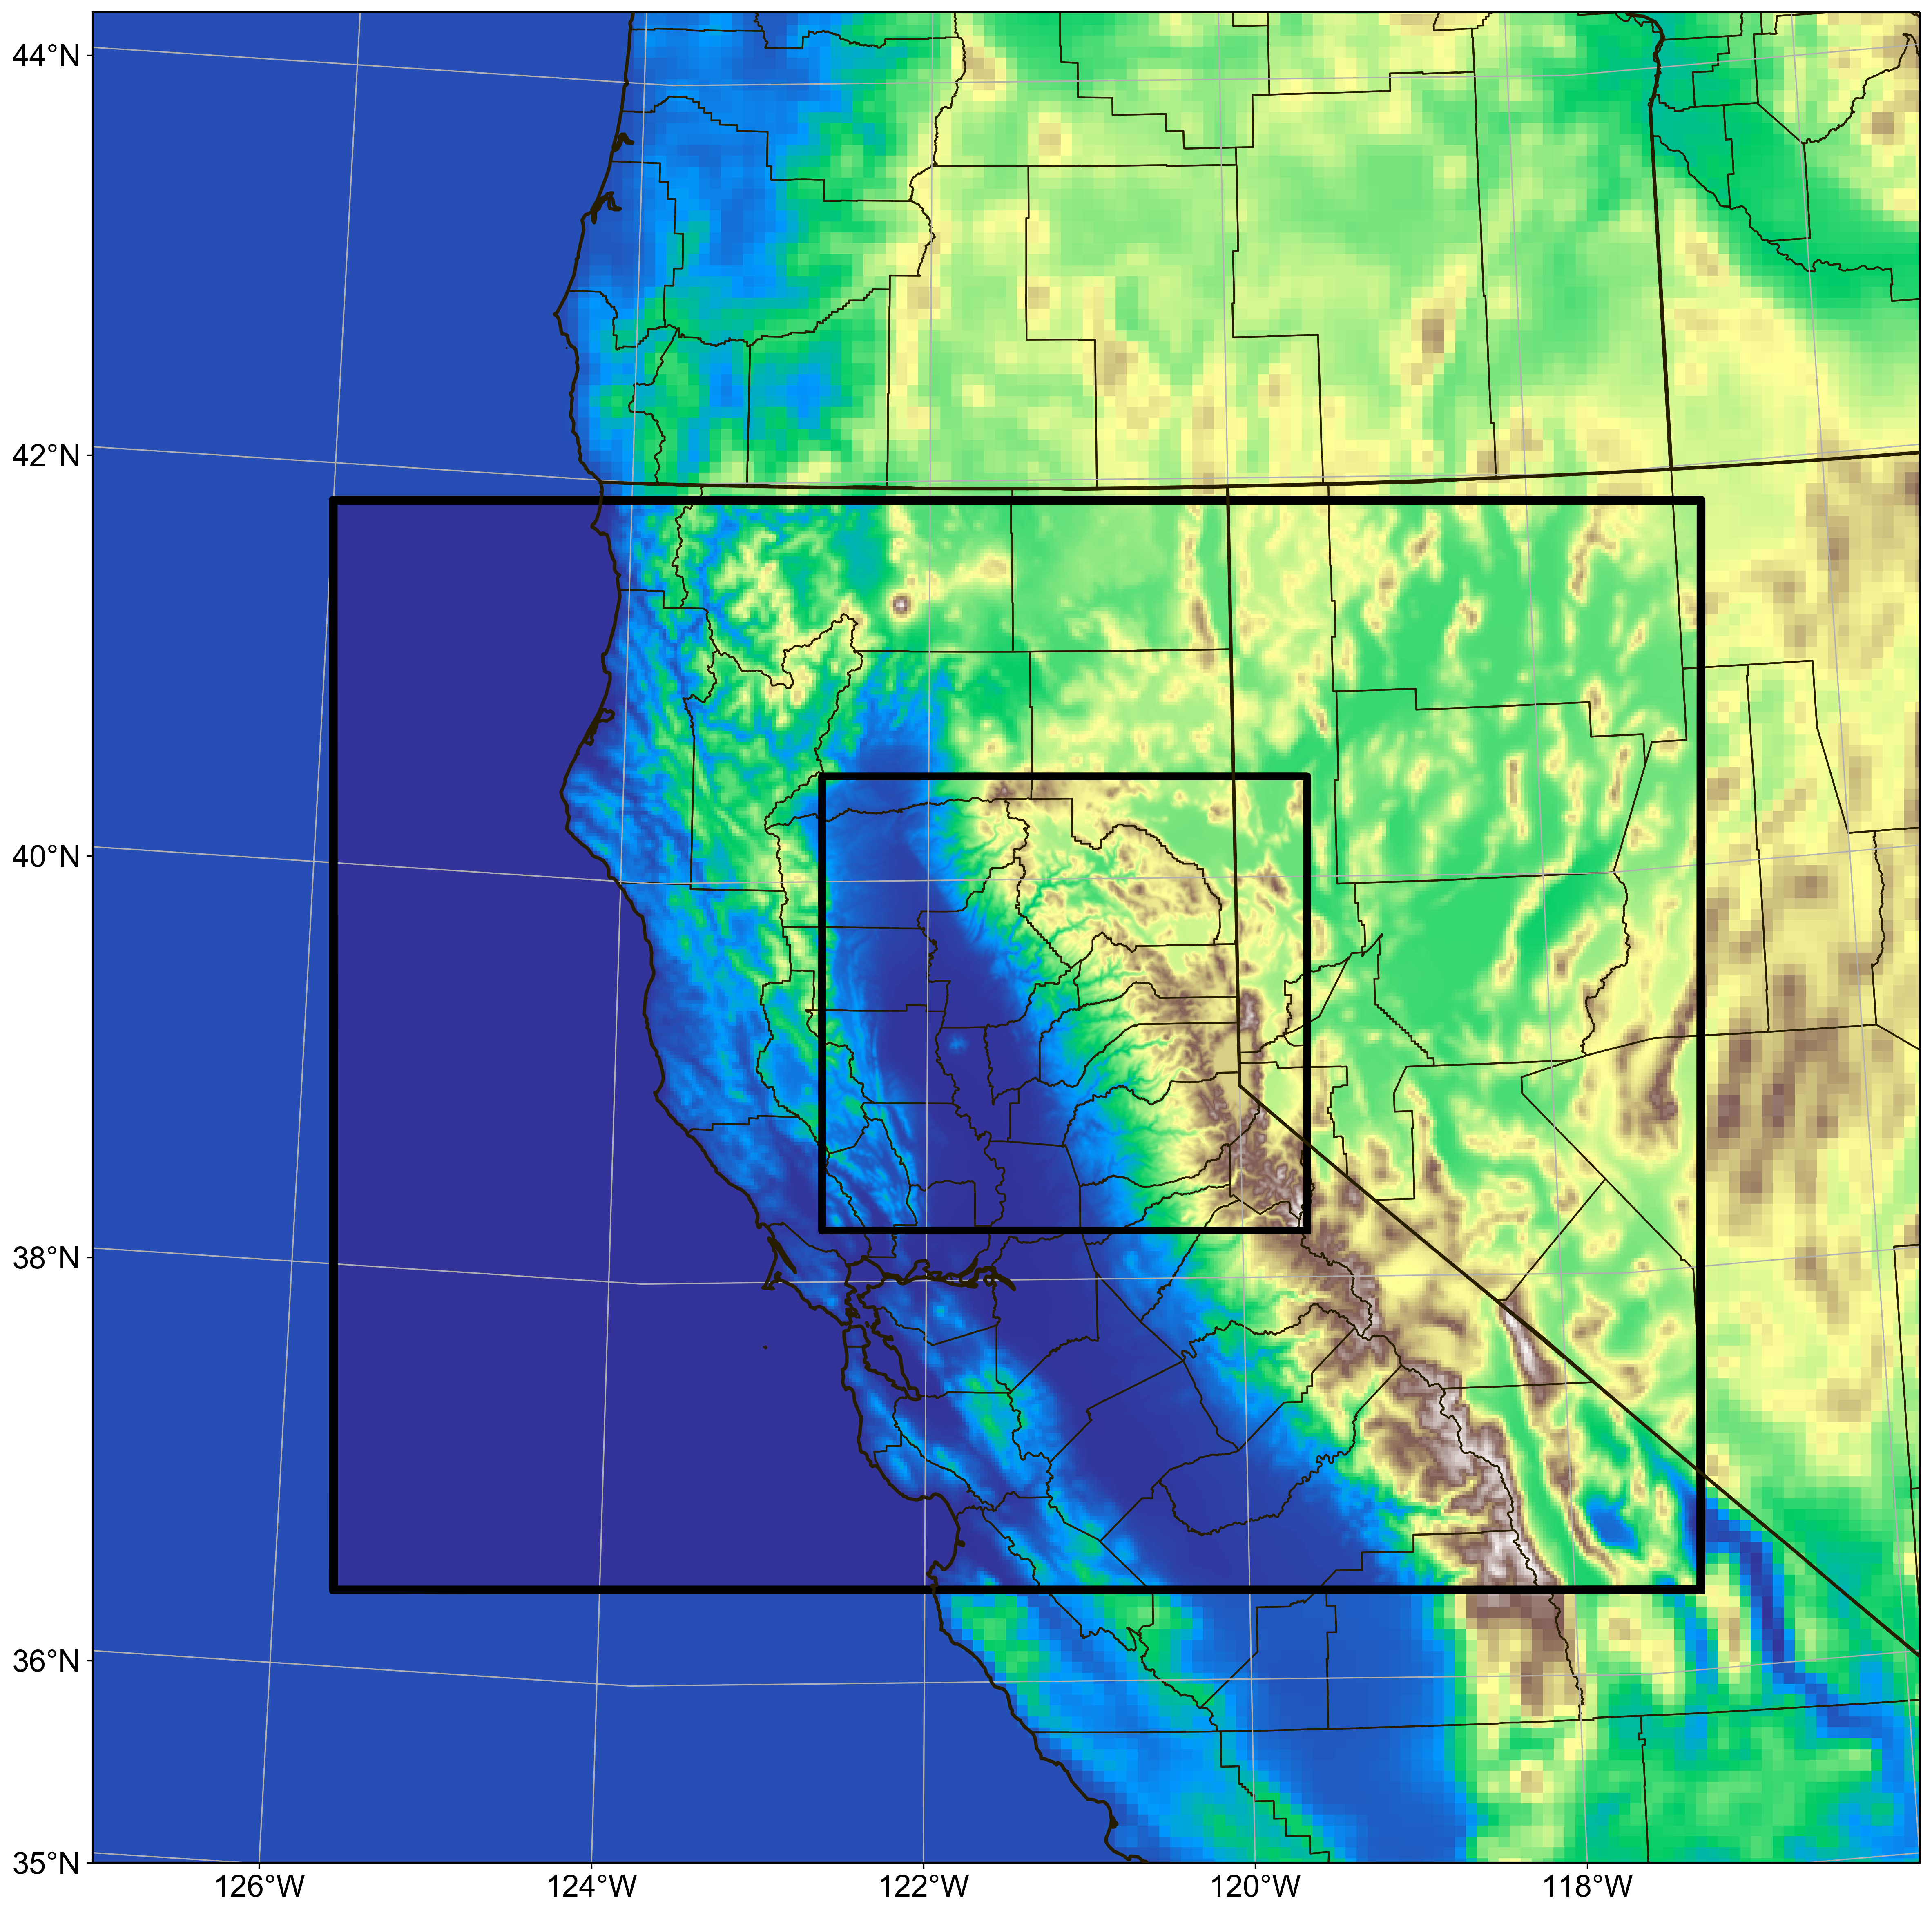

In [56]:
fig, ax = plt.subplots(figsize = (30,20),subplot_kw={'projection': cart_proj}, dpi = 300)
ax.set_extent([-116.+360.,-127.+360., 35, 44.25], crs=ccrs.PlateCarree())
plot_background(ax)
plt.pcolormesh(lon1,lat1,ds1.HGT_M.squeeze(), transform=ccrs.PlateCarree(), cmap = 'terrain')
plt.pcolormesh(lon2,lat2,ds2.HGT_M.squeeze(), transform=ccrs.PlateCarree(),cmap = 'terrain')
plt.pcolormesh(lon3,lat3,ds3.HGT_M.squeeze(), transform=ccrs.PlateCarree(), cmap = 'terrain')
fig.canvas.draw()
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-130,-128,-126,-124,-122,-120,-118,-116,-110, -50, -40, -30, -20, -11, 0, 10, 20, 30, 40, 50]
yticks = [10, 15, 20, 25, 30, 35,36,38, 40,42, 44, 50, 55, 60, 65, 70, 75, 80]
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.plot(ds2.corner_lons, ds2.corner_lats, transform = ccrs.PlateCarree(), color = 'k', linewidth = 4)
ax.plot(ds3.corner_lons, ds3.corner_lats, transform = ccrs.PlateCarree(), color = 'k', linewidth = 4)

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
    
    
plt.savefig('wrf_domains_terrain.png', dpi = 300)

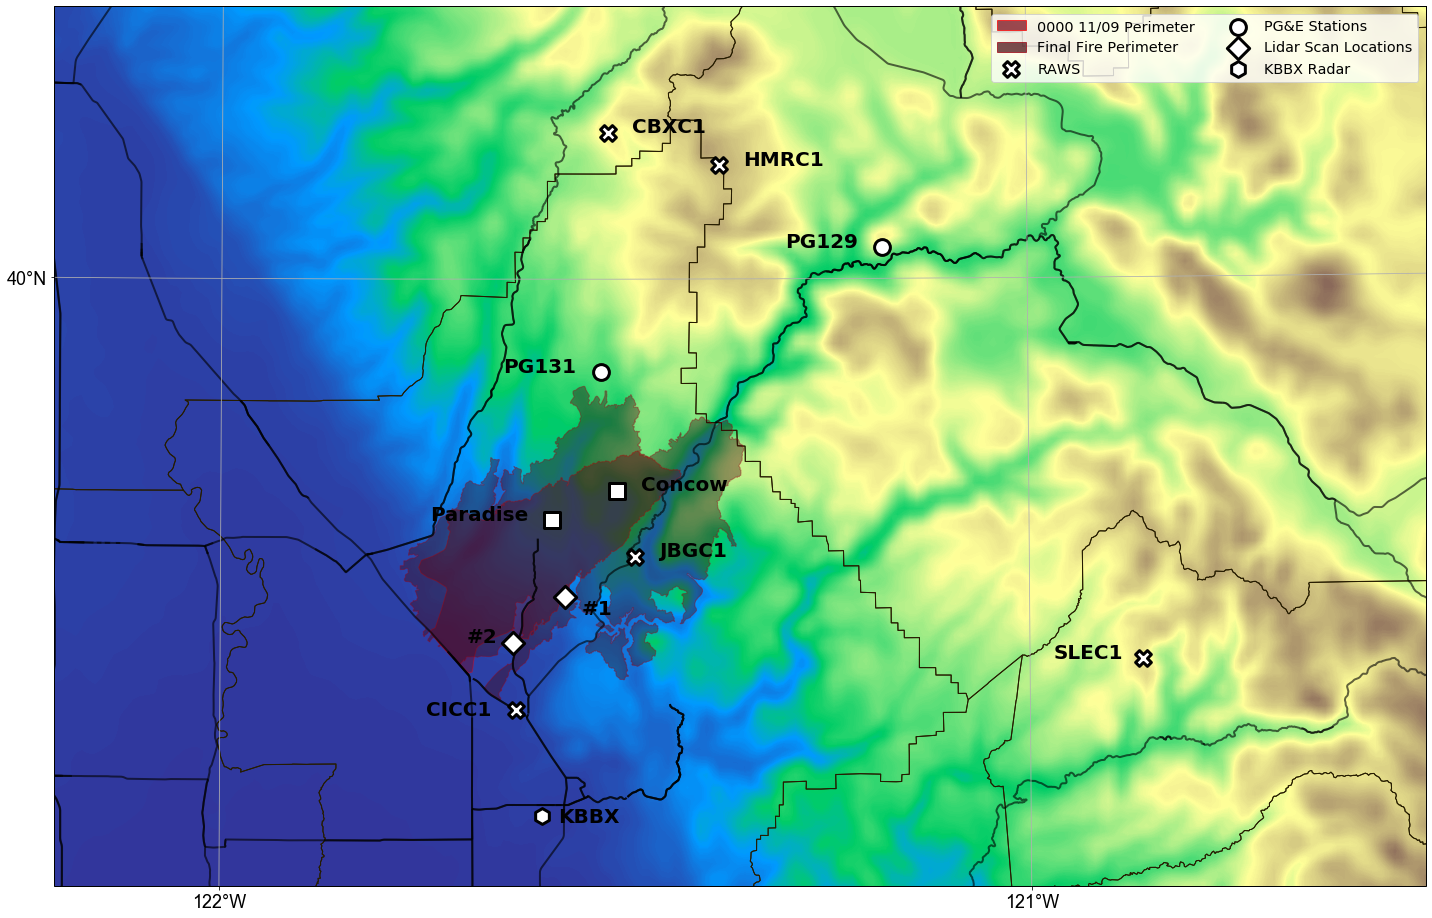

In [57]:
fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': cart_proj})
ax.set_extent([(ds3.corner_lons.max()-1)+360.,(ds3.corner_lons.min()+.5)+360., (ds3.corner_lats.min()+1.15), ds3.corner_lats.max()-.3], crs=ccrs.PlateCarree())
plot_background(ax)


fname = r'ca_camp_20181109_0000_dd83\ca_camp_20181109_0000_dd83.shp'
camp_fireper_2 = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='red', facecolor = '#75000e', alpha = .4)
ax.add_feature(camp_fireper_2,label = '2nd Fire Perimeter')
f1 = Patch(facecolor='#75000e', edgecolor='r',
                         label='0000 11/09/18 Perimeter', alpha = .7)

fname = r'ca_camp_20181125_1822_dd83\ca_camp_20181125_1822_dd83.shp'
final = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='#a10010', facecolor = '#42040b', alpha = .4)
ax.add_feature(final,label = 'Final Perimeter')
ff= Patch(facecolor='#42040b', edgecolor='#a10010',
                         label='Final Perimeter', alpha = .7)

fname = r'tl_2015_06_prisecroads\tl_2015_06_prisecroads.shp'
roads = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='black',facecolor = "None", linewidth = 2, alpha = .6)
ax.add_feature(roads)


plt.contourf(lon3,lat3,ds3.HGT_M.squeeze(), transform=ccrs.PlateCarree(),levels = np.arange(ds3.HGT_M.min(), ds3.HGT_M.max(), 10), cmap = 'terrain')

raws = ax.scatter(-120.86,39.636, s =250,  marker = 'X', label = 'RAWS', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-120.86-.025,39.636,'SLEC1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

ax.scatter(-121.52,40.14, s =250,  marker = 'X', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.52+.03,40.14,'CBXC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

ax.scatter(-121.382,40.109, s =250,  marker = 'X', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.382+.03,40.109,'HMRC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

ax.scatter(-121.635,39.589, s =250,  marker = 'X',  transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.635-.03,39.584,'CICC1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

ax.scatter(-121.488,39.735, s =250,  marker = 'X', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.488+.03,39.735,'JBGC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

pge = ax.scatter(-121.53,39.911, s =250,  marker = 'o', label = 'PG&E Station', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.53-.03,39.911,'PG131', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

ax.scatter(-121.18,40.03, s =250,  marker = 'o',  transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.18-.03,40.03,'PG129', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')


ax.scatter(-121.59,39.77, s =250,  marker = 's',  transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.59-.03,39.77,'Paradise', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

ax.scatter(-121.51,39.798, s =250,  marker = 's',  transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.51+.03,39.798,'Concow', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')


ld = ax.scatter(-121.574,39.697, s =250,  marker = 'D', label = 'Lidar Scan Location', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.574+.02,39.68,'#1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')

ax.scatter(-121.638,39.653, s =250,  marker = 'D',  transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.638-.02,39.653,'#2', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')


rad = ax.scatter(-121.603,39.488, s =250,  marker = 'h', label = 'KBBX Radar', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth='3')
ax.text(-121.603+.02,39.482,'KBBX', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold')


ax.legend((f1,ff,raws,pge,ld,rad), ('0000 11/09 Perimeter', 'Final Fire Perimeter', 'RAWS', 'PG&E Stations', 'Lidar Scan Locations', 'KBBX Radar'), fontsize = 'x-large',ncol = 2)

fig.canvas.draw()
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-124,-123,-122,-121,-120,-119,-118,-117,-116,]
yticks = [35,36,37,38,39, 40,41,42, 44,]
ax.gridlines(xlocs=xticks, ylocs=yticks)
# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
plt.tight_layout()    
plt.savefig('station_location_fper.png', dpi = 300)

In [ ]:
ca_camp_20181108_1754_dd83